# GitHubIssuesPart2(CleanVersion)

In [2]:
import xarray as xr
xr.set_options(display_style="html", display_expand_attrs=False);
from matplotlib import pyplot as plt
plt.style.use('default')
import cartopy
import cartopy.crs as ccrs
import argopy
import numpy as np
import os, shutil
from pathlib import Path

from argopy import DataFetcher as ArgoDataFetcher
from argopy import IndexFetcher as ArgoIndexFetcher
from argopy import TopoFetcher 

argo_loader = ArgoDataFetcher(src='erddap', parallel=True, qc=1) #This limits the data to the highest quality control flag (QC = 1)

ValueError: 'c' argument has 900 elements, which is inconsistent with 'x' and 'y' with size 2100.

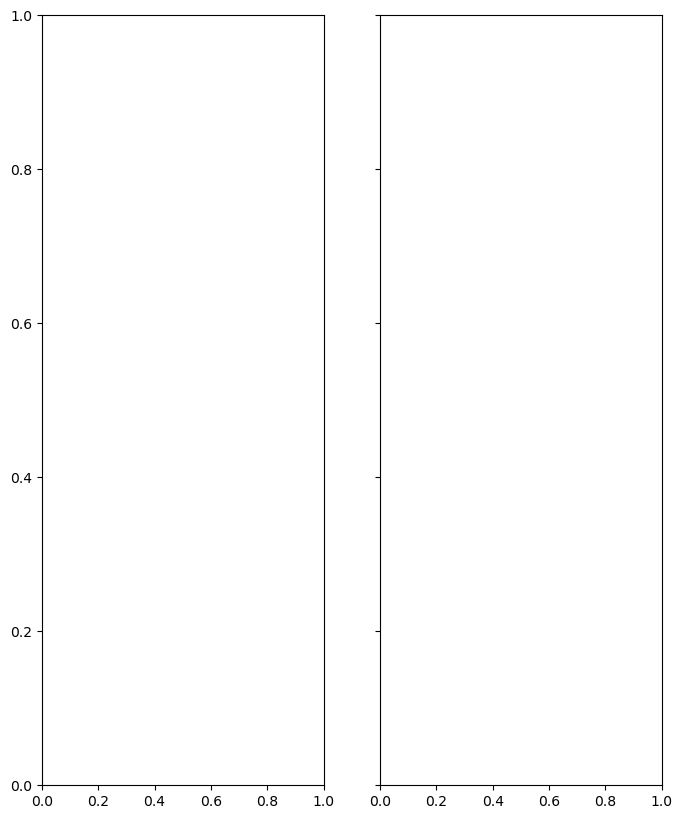

In [3]:
# This is the new code I created to make a color bar, but there is a mismatch in dimensions that I am having a hard time pinpointing. My guess is that it has something to do with there being nans in the data; 

sliced_data_list = []

a_values = [5903608] #, 5904128, 5904977, 4900816, 4902251, 4902149, 4902947, 4902935, 5903603]
for a in a_values:
    
    apDS = argo_loader.float(a).load().data
    data1 = apDS.argo.point2profile()
    data2 = data1.set_xindex("TIME")
    sliced_data = data2.sel(TIME=slice('2017-03-01','2017-12-31'))
   
    # Filter data with NaNs in the 'N_PROF' dimension
    sliced_data_filtered = sliced_data.dropna(dim='N_PROF', how='any')
    sliced_data_filtered = sliced_data.dropna(dim='N_LEVELS', how='any')
    
    # Append to the sliced_data_list only if there are no NaNs left
    if len(sliced_data_filtered) > 0:
        # Drop the 'N_PROF' dimension to avoid conflicting indexes
        sliced_data = sliced_data_filtered.drop('N_PROF')
        sliced_data_list.append(sliced_data_filtered)


import pandas as pd

for i, sliced_data in enumerate(sliced_data_list):
    
    fig, ax = plt.subplots(1, 2, figsize=(8,10), sharey=True) 

    #Calculate the max and min latitude and longitude values!
    max_lat = sliced_data.LATITUDE.max().values
    min_lat = sliced_data.LATITUDE.min().values
    max_lon = sliced_data.LONGITUDE.max().values
    min_lon = sliced_data.LONGITUDE.min().values
    min_time = pd.to_datetime(sliced_data.TIME.min().values).strftime('%Y-%m-%d')
    max_time = pd.to_datetime(sliced_data.TIME.max().values).strftime('%Y-%m-%d')

    # Get the month of each profile and repeat the values for each profile
    #sliced_data = sliced_data_filtered.where(~np.isnan(sliced_data.TEMP) & ~np.isnan(sliced_data.PRES), drop=True)


    months = sliced_data_filtered.TIME.dt.month
    months_repeated = np.repeat(months.dropna(dim='N_PROF'), sliced_data_filtered.N_PROF.size)
    
    #Calculate the number of profiles DIMENSION!
    n_prof_value = sliced_data.N_PROF.values[0]
    
    #Temperature
    sc1 = ax[0].scatter(sliced_data.TEMP,-sliced_data.PRES, c=months_repeated, alpha=0.5, cmap="jet")
    ax[0].set_xlabel('Sea Temperature IN SITU ITS-90 in Celcius') 
    ax[0].set_ylabel('Sea Pressure (dbar)')
    ax[0].set_title('CTD Graphs')
    ax[0].grid()
   
    #Salinity
    sc2 = ax[1].scatter(sliced_data.PSAL,-sliced_data.PRES, c=months_repeated, alpha=0.5, cmap="jet")
    ax[1].set_title(f"WSO Identifier - {a_values[i]}")
    ax[1].set_xlabel('Practical Salinity (PSU)')
    ax[1].grid()

    #Provide a text box with important information like lat, lon, and the number of profiles!
    text_plot = f"Min Lat: {min_lat:.2f}\nMax Lat: {max_lat:.2f}\nMin Lon: {min_lon:.2f}\nMax Lon: {max_lon:.2f}\nMin Time: {min_time}\nMax Time: {max_time}"
    ax[1].text(0.95, 0.05, text_plot, transform=ax[1].transAxes, ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    
    ax.set_title(f"T/S diagram for float {prof.PLATFORM_NUMBER[0].astype(str).values}")
    ax.set_ylabel("potential temperature")
    ax.set_xlabel(f"{prof.PSAL.long_name}")
    fig.colorbar(sc1, label="Profiles by Month")
    fig.colorbar(sc2, label="Profiles by Month")

# Display the plot
plt.show()

In [4]:
print(len(sliced_data_filtered))
print(len(sliced_data_list))

15
1
